# Basic Forecasting Methods

Firstly i going to introduce very basic methods and implementations and demonstrations.

## Average Approach

Just simple using average of all values to create a prevision.

$$\hat{y}_{T+h|T} = (y_1+\dots+y_T)/T$$

## Naive Approach

Just using the last value.

$$\hat{y}_{T+h|T} = y_T$$

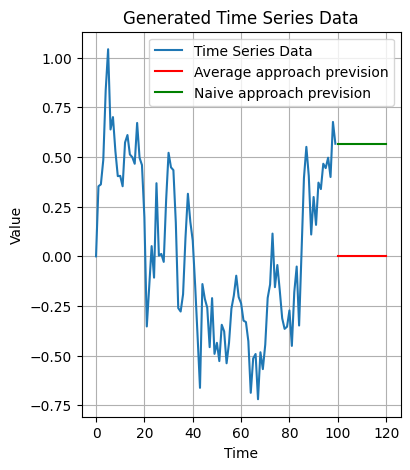

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def average(data):
    result = 0
    for t in data:
        result += t
    return result//data.size

np.random.seed(0)
data = np.zeros(100)
for t in range(1, 100):
    data[t] = 0.8 * data[t-1] + 0.2 * np.random.normal()

## Average approach
x2 = np.linspace(100, 120, 120)
y2 = np.full(120, average(data))

## Naive approach
x3 = np.linspace(100, 120, 120)
y3 = np.full(120, data[-1])


plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(data, label='Time Series Data')
plt.plot(x2, y2, label='Average approach prevision', color='r')
plt.plot(x3, y3, label='Naive approach prevision', color='g')
plt.title('Generated Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

## Drift Approach

$$ \hat{y}_{T+h|Y} = y_T + h\frac{y_T-y_1}{T-1}$$

Is visible based on the equation of a Straigh Line here $\frac{y_T-y_1}{T-1}$ is the Slope, basically uses the angle of the first and last value of the data.

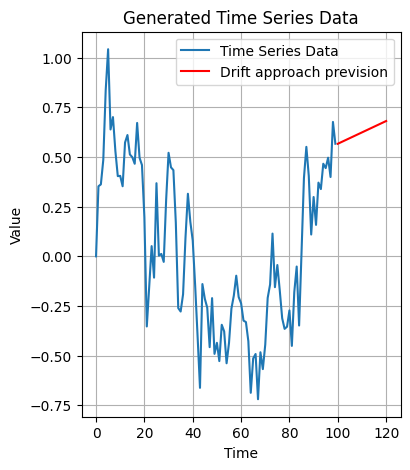

In [19]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
T=100
data = np.zeros(T)
for t in range(1, T):
    data[t] = 0.8 * data[t-1] + 0.2 * np.random.normal()

## Drift approach
x2 = np.linspace(T, T + 20, 20)
y2 = data[-1] + (x2 - T)*((data[-1]-data[0])/(T-1)) 

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(data, label='Time Series Data')
plt.plot(x2, y2, label='Drift approach prevision', color='r')
plt.title('Generated Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

## Seasonal Naive Approach

$$ \hat{y}_{T+h|Y}=y_{Y+h-m(k+1)} $$

where $m$ is the seasonal period and $h$ is the smallest integer greater than $(h-1)/m$

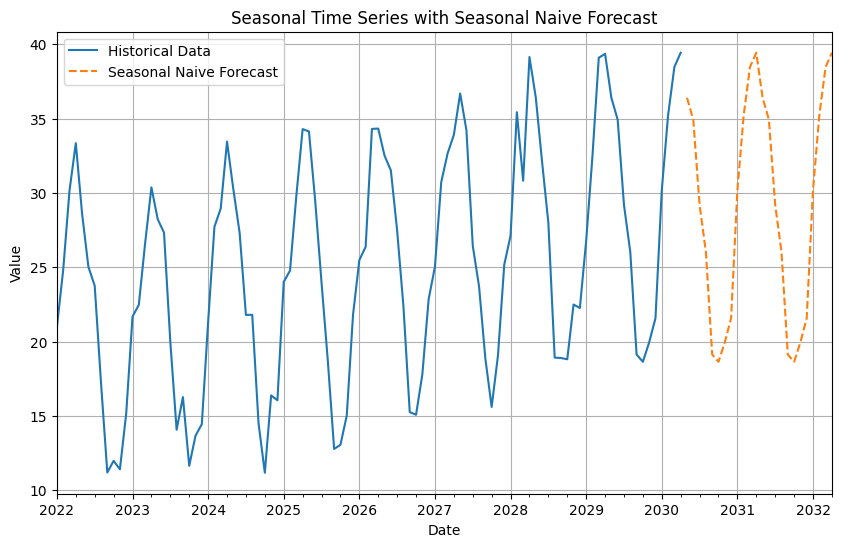

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
periods = 100  
seasonal_period = 12
amplitude = 10 
trend = 0.1
noise_level = 2 

time = np.arange(periods)
seasonal = amplitude * np.sin(2 * np.pi * time / seasonal_period)
trend = trend * time
noise = noise_level * np.random.randn(periods)

# Create time series
series = 20 + trend + seasonal + noise

dates = pd.date_range(start='2022-01-01', periods=periods, freq='ME')
time_series = pd.Series(series, index=dates)

# Forecast using Seasonal Naive Approach
forecast_periods = 24
last_season = time_series[-seasonal_period:]

forecasts = np.tile(last_season.values, int(np.ceil(forecast_periods / seasonal_period)))[:forecast_periods]

forecast_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='ME')
forecast_series = pd.Series(forecasts, index=forecast_dates)

plt.figure(figsize=(10, 6))
time_series.plot(label='Historical Data')
forecast_series.plot(label='Seasonal Naive Forecast', linestyle='--')
plt.title('Seasonal Time Series with Seasonal Naive Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Series Decomposition

We are going to decompose the time series in 3 principal components: Trends, Seasonality and residue.

There two types of models, addictive and multiplicative.

Firstly we are going to calculate the Trend Component $T_t$ with is basically the moving average (SMA - Simple Moving Average) and the paratemer of smoothing windows $k$.
$$ T_t = \frac{1}{k} \sum_{i=-\lfloor k/2 \rfloor}^{\lfloor k/2 \rfloor} y_{t+i} $$

After that we can calculate the Seasonality Component $S_t$

$$ S_t = \frac{1}{n} \sum_{i=0}^{n-1} (y_{t+ki} - T_{t+ki}) $$

And in the end we can calculute the residue.

$ e_t = y_t - T_t - S_t$ for addictive model.

$ e_t = \frac{y_t}{T_t S_t} $ for multiplicative model.

Is visible that the residue is just the timeseries with Trend and Seasonality Component removed.

## Minimization of Mean Squared Error (MSE)

To calculate the $k$ value we must choose the minimal mean squared error, the MSE is defined as:

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n{(y_i-\hat{y}_i)}^2 $$

Here $\hat{y}$ are the previsions, to minimize $k$ in $T_t$:

Lets $T(t, k)$:

$$ T(t, k) = \frac{1}{k} \sum_{i=-\lfloor k/2 \rfloor}^{\lfloor k/2 \rfloor} y_{t+i} $$

Then

$$k* =  \arg \min_k \frac{1}{n} \sum_{i=1}^n{(y_i-T(t,k))}^2$$

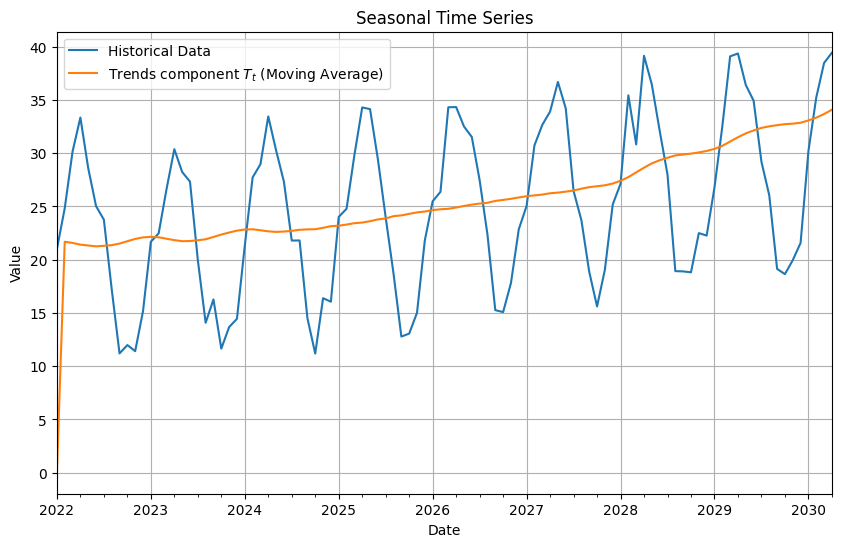

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
periods = 100  
seasonal_period = 12
amplitude = 10 
trend = 0.1
noise_level = 2 

time = np.arange(periods)
seasonal = amplitude * np.sin(2 * np.pi * time / seasonal_period)
trend = trend * time
noise = noise_level * np.random.randn(periods)

series = 20 + trend + seasonal + noise

dates = pd.date_range(start='2022-01-01', periods=periods, freq='ME')
time_series = pd.Series(series, index=dates)

k = 60
treding_series = np.zeros(periods)

def sma(data, t): ## moving average to decompose trendings
    sum, rangediv2 = 0, k//2
    for i in range(-rangediv2, rangediv2):
        index = t - i
        index = 0 if index <= 0 else index
        index = data.size - 1 if index >= data.size else index
        sum += data[index] 
    return sum/k

def decompose_seasonality(data, trends,  t):
    sum = 0
    for i in range(1, data.size):
        index = t + i*k
        index = 0 if index <= 0 else index
        index = data.size - 1 if index >= data.size else index
        sum += data[index] - trends[index]
    return sum/data.size

for i in  range(1, periods):
    treding_series[i] = sma(series, i)


plt.figure(figsize=(10, 6))
time_series.plot(label='Historical Data')
pd.Series(treding_series, index=dates).plot(label='Trends component $T_t$ (Moving Average)')
plt.title('Seasonal Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()